## EPO OPS API - Usage Example

Open Patent Services (OPS) is a web service which provides access to the EPO's raw data via a standardised XML interface. It does this using RESTful architecture. The present notebook illustrates its usage.

To use OPS, registration is required, see: [link](https://www.epo.org/searching-for-patents/data/web-services/ops.html)

Registering is **free** as is using the service! Nevertheless, non-paying users are limited to use up to **4 GB** of data **per week.** 

To read more about what is possible wiht OPS, just have a look at the documentation at the same page above, under "Further information".

The repository of the present project can be found here: [link](https://github.com/botturag91/Notebooks-public/001)


# Preparing environment

## Project Folder Structure

```
project_root_folder
│   EPO OPS API Abstract Retrieval.ipynb    
│   requirements.txt                        # Requirements to install
|   keys.cfg                                # API Keys
|   images/                                  # Directory containing notebook images
```

## Installing packages from requirements file

In [13]:
import pip

In [14]:
def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])       

In [28]:
with open("./requirements.txt", "r") as f:
    for package in f.readlines():
        import_or_install(package)

# How does it work

The EPO OPS API provides a serie of service. Here is illustrated the use of two of them:

- Search service: Provides patent number based on a specific query used
- Abstract service: Provides the abstract of patent document based on a patent number 

In [16]:
import requests # Handles HTTP requests
from configparser import ConfigParser # Retrieves secret API keys from config file
from pandas import json_normalize # Flattens the json response 
import ast # Evaluate an expression node or a string containing a Python literal 
import json # Handles json 
from base64 import b64encode  # Provides Standard Base64 Encoding for the API keys 
import urllib # Encodes a query in url format for APi request
import time
from timeout import random_timeout  # Randomized sleep() function to avoid RobotDetect Errors
from fake_useragent import UserAgent  # Fakes an header for the HTTP request 

## Retrieve API keys from config file in same PATH as the present notebook

In order to take care of the credentials, after they have been optained, add these in a configuration file named "keys.cfg", having the following structure:

![credentials.png](./images/credentials.png)
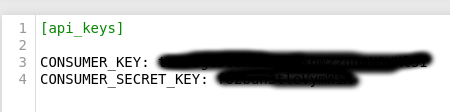

In [17]:
parser = ConfigParser()
_ = parser.read("keys.cfg")
CONSUMER_KEY = parser.get("api_keys", "CONSUMER_KEY")
CONSUMER_SECRET_KEY = parser.get("api_keys", "CONSUMER_SECRET_KEY")

In [18]:
def get_token():
    """
    A token requested so to be used in every request to the API. The token 
    is obtained by post request the encoded key, which is made from the 
    CONSUMER_KEY and CONSUMER_SECRET_KEY received
    """

    # Standard Base64 Encoding
    KEY = b64encode(
        (CONSUMER_KEY + ":" + CONSUMER_SECRET_KEY).encode("utf-8")
    ).decode("utf-8")

    PAYLOAD = {"grant_type": "client_credentials"}
    HEADER_POST = {
        "Authorization": "Basic {}".format(KEY),
        "Content-Type": "application/x-www-form-urlencoded",
    }

    with requests.Session() as s:
        s.headers.update(HEADER_POST)
        resp = s.post("https://ops.epo.org/3.2/auth/accesstoken", data=PAYLOAD)
        post = ast.literal_eval(resp.text)
        TOKEN = post["access_token"]

    return TOKEN

In [19]:
def request(TOKEN: str, URL: str):
    """
    The request utilizes a randomized User agent field to avoid RobotDetected Errors. 
    The request is a HTTP GET request obatined in json format.
    A random timeout is also used to avoid RobotDeceted Errors. 
    The type of services to make use of and the associated parameters are defined in the URL
    """

    ua = UserAgent()

    HEADER_GET = {
        "Authorization": "Bearer " + str(TOKEN),
        "Content-Type": "application/x-www-form-urlencoded",
        "Accept": "application/json",  
        "User-Agent": str(ua.chrome),
    }

    random_timeout(2, 20)
        
    with requests.Session() as s:
        s.headers.update(HEADER_GET)

        response = s.get("http://ops.epo.org/rest-services/" + str(URL))

    return response

In [20]:
def get_patent_number(query: str):
    """
    The present function retrieves patent numbers meeting the query. 
    Only a maximum of 100 results can be retreived in this way, per request. 
    To overcome this limit, more requests need to be made. 
    """
    TOKEN = get_token()

    QUERY = f"{query}"

    url_query = urllib.parse.urlencode({"q": QUERY, "Range": 1})
    url_service = "published-data/search?"

    URL = url_service + url_query

    response = request(TOKEN, URL)

    if response.ok:

        json_search_response = json.loads(response.text)

        search_results_json = json_search_response["ops:world-patent-data"]["ops:biblio-search"]\
            ["ops:search-result"]["ops:publication-reference"]

        try:
            patent_number = (
                search_results_json[0]["document-id"]["country"]["$"]
                + search_results_json[0]["document-id"]["doc-number"]["$"]
            )

        except:
            patent_number = (
                search_results_json["document-id"]["country"]["$"]
                + search_results_json["document-id"]["doc-number"]["$"]
            )

    else:

        patent_number = None

    return patent_number

In [21]:
def get_patent_abstract(pub_number: str):
    """
    The present function retrieves the abstract and other bibliographic information given a patent number. 
    In case the patent number corresponds to diffrent publication types, more than one abstract is retrieved. 
    The abstract is given in all the languages it is present in the application,
    """
    TOKEN = get_token()
    URL = f"published-data/publication/epodoc/{pub_number}/abstract"
    response = request(TOKEN, URL)

    try:
        response_json = json.loads(response.text)

    except Exception:
        response_json = None

    return response_json

## Example of Usage - CRISPR

To show how the API can be used, I have decided to try to recieved the abstract of a patent document related to CRISPRS technology. See the application here below.


![CRISPR_patent_app.png](./images/CRISPR_patent_app.png)

In [22]:
query = "ti=CRISPR-CAS SYSTEMS AND METHODS FOR ALTERING EXPRESSION OF GENE PRODUCTS pn=EP"

In [23]:
p_number = get_patent_number(query)
p_abstract = get_patent_abstract(p_number)

In [24]:
print(f"Patent Publication Number: \n{p_number}")
print("\n")
print(f"Patent Abstract: \n{p_abstract}")

Patent Publication Number: 
EP2998400


Patent Abstract: 
{'ops:world-patent-data': {'@xmlns': {'ops': 'http://ops.epo.org', '$': 'http://www.epo.org/exchange', 'xlink': 'http://www.w3.org/1999/xlink'}, 'exchange-documents': {'exchange-document': {'@country': 'EP', '@doc-number': '2998400', '@kind': 'A1', 'bibliographic-data': {'publication-reference': {'document-id': [{'@document-id-type': 'docdb', 'country': {'$': 'EP'}, 'doc-number': {'$': '2998400'}, 'kind': {'$': 'A1'}, 'date': {'$': '20160323'}}, {'@document-id-type': 'epodoc', 'doc-number': {'$': 'EP2998400'}, 'date': {'$': '20160323'}}]}, 'parties': {}}, 'abstract': {'@lang': 'en', 'p': {'$': 'The invention provides for systems, methods, and compositions for altering expression of target gene sequences and related gene products. Provided are vectors and vector systems, some of which encode one or more components of a CRISPR complex, as well as methods for the design and use of such vectors. Also provided are methods of directin

In [25]:
flattened_json = json_normalize(p_abstract) # I find in many instances easier to flatten the json to get to some values

In [26]:
abstract = flattened_json["ops:world-patent-data.exchange-documents.exchange-document.abstract.p.$"][0]

In [27]:
abstract

'The invention provides for systems, methods, and compositions for altering expression of target gene sequences and related gene products. Provided are vectors and vector systems, some of which encode one or more components of a CRISPR complex, as well as methods for the design and use of such vectors. Also provided are methods of directing CRISPR complex formation in eukaryotic cells and methods for utilizing the CRISPR-Cas system.'